In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [2]:
n_rand = 666 # random seed
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/tabular-data'
data_file = 'ros-tabular-data.parquet'
data_path = os.path.join(data_dir, data_file)

# Linear baseline

In [27]:
# create train/test set
df = pd.read_parquet(data_path)
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['rho_eff', 'sa_eff']
df = df.sample(1_000_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n_rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=n_rand)

# train
reg = LinearRegression()
reg.fit(X_train, y_train)

# run model on val data
y_val_pred = reg.predict(X_val)

In [28]:
# create output dataframe
df_val_out = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out['rho_eff_pred'] = y_val_pred[:, 0]
df_val_out['sa_eff_pred'] = y_val_pred[:, 1]

# get score
r2_rho = r2_score(df_val_out['rho_eff_truth'], df_val_out['rho_eff_pred'])
r2_sa = r2_score(df_val_out['sa_eff_truth'], df_val_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

R2 for effective density = 0.9240626030742362
R2 for effective surface area = 0.9009469898199721


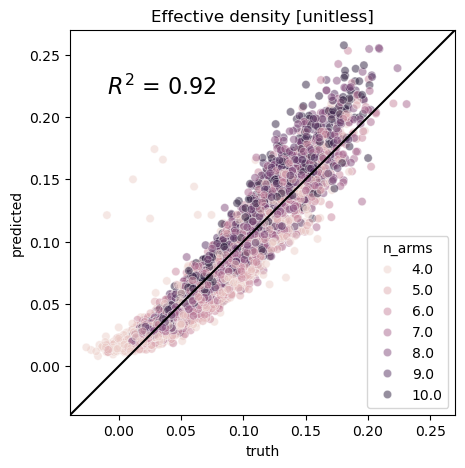

In [29]:
# plot
df_subset = df_val_out.sample(10_000, random_state=n_rand)
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_subset, x='rho_eff_pred', y='rho_eff_truth', 
hue='n_arms', alpha=0.5,
legend='full', edgecolor='white')
# sns.scatterplot(data=df_subset, x='rho_pred', y='rho_truth', 
# size='n_arms', alpha=0.5, palette=mpl.colormaps['plasma'], 
# legend='full')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('truth')
ax.set_title('Effective density [unitless]')
ax.text(0.2, 0.75, f'$R^2$ = {r2_rho:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

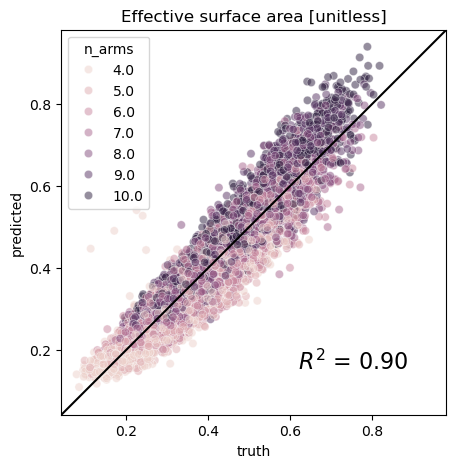

In [30]:
# plot
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_subset, x='sa_eff_pred', y='sa_eff_truth', hue='n_arms', alpha=0.5, legend='full')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('truth')
ax.set_title('Effective surface area [unitless]')
ax.text(0.6, 0.2, f'$R^2$ = {r2_sa:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

# RF

## rho_eff

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(600000, 8)
(600000, 2)
(200000, 8)
(200000, 2)


In [32]:
%%time
# train 
rf = RandomForestRegressor(max_depth=15, random_state=n_rand, n_jobs=16)
rf.fit(X_train, y_train)

# run model on val data
y_val_pred_rf = rf.predict(X_val)

CPU times: user 9min 7s, sys: 275 ms, total: 9min 7s
Wall time: 37.4 s


R2 value for effective density: 0.9407317099924094


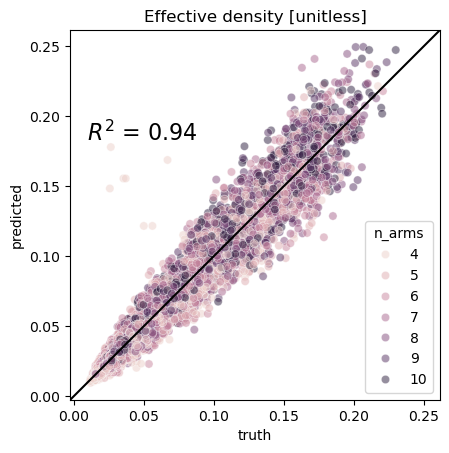

In [43]:
# create output dataframe
df_val_out_rf = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out_rf['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out_rf['rho_eff_pred'] = y_val_pred_rf[:, 0]
df_val_out_rf['sa_eff_pred'] = y_val_pred_rf[:, 1]

df_rf_subset = df_val_out_rf.sample(10_000)
# r2 value
r2 = r2_score(df_val_out_rf['rho_eff_pred'], df_val_out_rf['rho_eff_truth'])
print(f'R2 value for effective density: {r2}')

# plot scatter
fig, ax = plt.subplots()
sns.scatterplot(data=df_rf_subset, x='rho_eff_pred', y='rho_eff_truth', hue='n_arms', alpha=0.5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('truth')
ax.set_title('Effective density [unitless]')
ax.text(0.25, 0.65, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

R2 value for effective density: 0.9407317099924094


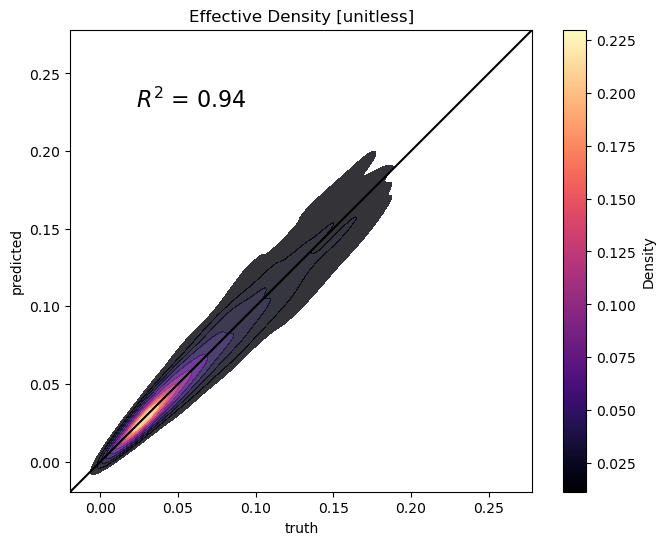

In [52]:
# r2 value
r2 = r2_score(df_val_out_rf['rho_eff_pred'], df_val_out_rf['rho_eff_truth'])
print(f'R2 value for effective density: {r2}')

# plot density plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot density plot (using kdeplot for density)
sns.kdeplot(data=df_rf_subset, x='rho_eff_pred', y='rho_eff_truth', cmap='magma', fill=True, ax=ax, alpha=0.8)

# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')

# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('truth')
ax.set_title('Effective Density [unitless]')

# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=df_rf_subset['rho_eff_pred'].min(), vmax=df_rf_subset['rho_eff_pred'].max()))
sm.set_array([])  # Empty array to create colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Density')

plt.show()

R2 value for effective density: 0.9407317099924094


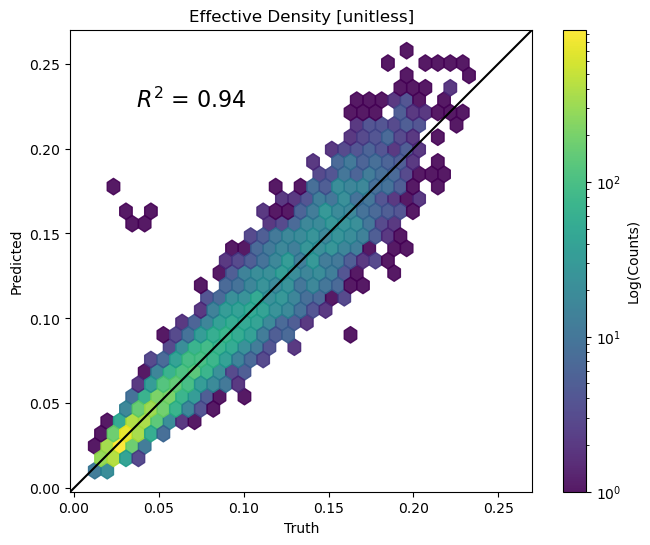

In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Create output dataframe
df_val_out_rf = y_val.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_val_out_rf['n_arms'] = df['n_arms'].iloc[X_val.index]
df_val_out_rf['rho_eff_pred'] = y_val_pred_rf[:, 0]
df_val_out_rf['sa_eff_pred'] = y_val_pred_rf[:, 1]

df_rf_subset = df_val_out_rf.sample(10_000)

# R2 value
r2 = r2_score(df_val_out_rf['rho_eff_pred'], df_val_out_rf['rho_eff_truth'])
print(f'R2 value for effective density: {r2}')

# Plot hexbin density plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create hexbin plot
hb = ax.hexbin(df_rf_subset['rho_eff_pred'], df_rf_subset['rho_eff_truth'], gridsize=30, 
               cmap='viridis', mincnt=1, alpha=0.9, bins='log')

# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')

# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')

# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('Predicted')
ax.set_xlabel('Truth')
ax.set_title('Effective Density [unitless]')

# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Show the plot
plt.show()


## sa_eff

R2 value for effective surface area: 0.9071514817111087


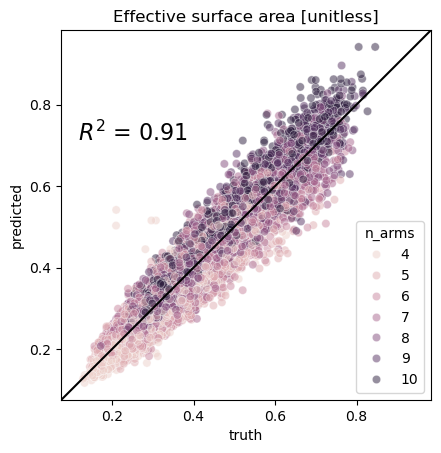

In [45]:
# r2 value
r2 = r2_score(df_val_out_rf['sa_eff_pred'], df_val_out_rf['sa_eff_truth'])
print(f'R2 value for effective surface area: {r2}')

# plot scatter
fig, ax = plt.subplots()
sns.scatterplot(data=df_rf_subset, x='sa_eff_pred', y='sa_eff_truth', hue='n_arms', alpha=0.5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('predicted')
ax.set_xlabel('truth')
ax.set_title('Effective surface area [unitless]')
ax.text(0.25, 0.65, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

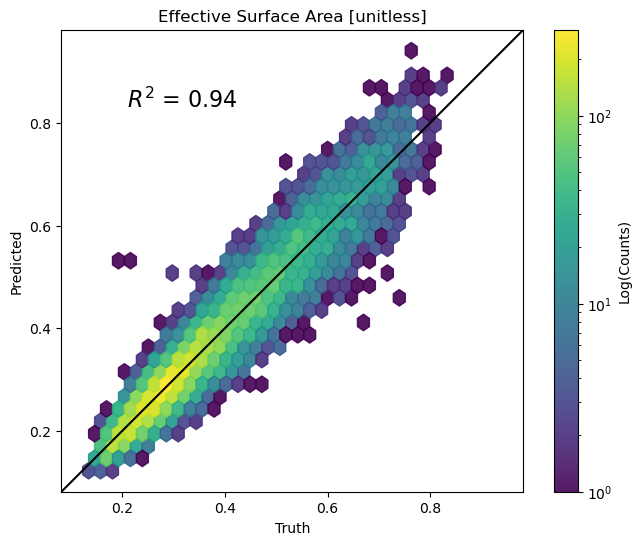

In [58]:
# Plot hexbin density plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create hexbin plot
hb = ax.hexbin(df_rf_subset['sa_eff_pred'], df_rf_subset['sa_eff_truth'], gridsize=30, 
               cmap='viridis', mincnt=1, alpha=0.9, bins='log')

# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')

# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')

# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('Predicted')
ax.set_xlabel('Truth')
ax.set_title('Effective Surface Area [unitless]')

# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)

# Show the plot
plt.show()
